In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import special

In [2]:
base_dir = 'model_scores/deberta_v3_large/open_ai_summarize_from_feedback'

In [3]:
def energy_score(logits, temperature=1.0):
    assert logits.shape[1] == 2
    # implements energy based out of distribution detection
    return (-temperature) * special.logsumexp(logits / temperature, axis=1)
    #return -temperature * (np.log(np.exp(logits / temperature).sum(axis=1)))

In [4]:
def calc_tnr(id_test_ood_scores, ood_test_ood_scores):
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    fpr, tpr, thresholds = roc_curve(trues, scores)
    return 1 - fpr[np.argmax(tpr>=.95)]

def calc_auroc(id_test_ood_scores, ood_test_ood_scores):
    #calculate the AUROC
    scores = np.concatenate((id_test_ood_scores, ood_test_ood_scores))
    trues = np.array(([0] * len(id_test_ood_scores)) + ([1] * len(ood_test_ood_scores)))
    result = roc_auc_score(trues, scores)

    return result

In [5]:
auroc_all, fpr_all = {}, {}
for inst in ['prompt', 'response', 'prompt_and_response']:
    aurocs, fprs = {}, {}
    perturbed_logits = {}
    for f in glob(f'{base_dir}/{inst}/*'):
        df = pd.read_csv(f)
        perturbation = float(os.path.basename(f).split('_')[0][:2]) / 10
        perturbed_logits[perturbation] = df.values
    energy_scores = {}
    for perturbation, logits in perturbed_logits.items():
        energy_scores[perturbation] = energy_score(logits)

    id_test_ood_scores = energy_scores[0.0]
    for perturbation in sorted(energy_scores):
        ood_test_ood_scores = energy_scores[perturbation]
        auroc = calc_auroc(id_test_ood_scores, ood_test_ood_scores)
        tnrATtpr95 = calc_tnr(id_test_ood_scores, ood_test_ood_scores)
        aurocs[perturbation] = auroc
        fprs[perturbation] = 1 - tnrATtpr95
    auroc_all[inst] = aurocs
    fpr_all[inst] = fprs

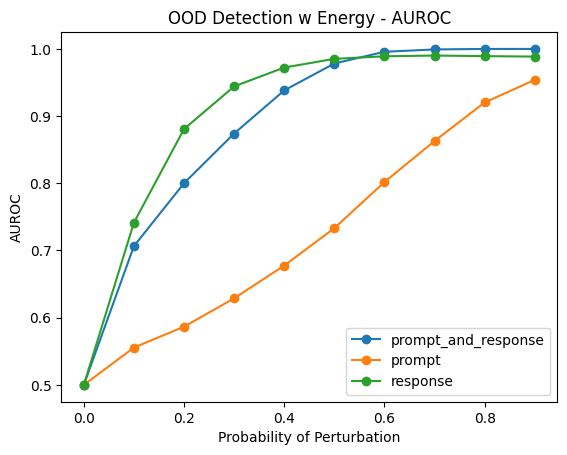

In [9]:
for inst in ['prompt_and_response', 'prompt', 'response']:
    aurocs =  auroc_all[inst]
    plt.plot(list(aurocs.keys()), list(aurocs.values()), label=inst, marker='o')
plt.xlabel('Probability of Perturbation')
plt.ylabel('AUROC')
plt.title('OOD Detection w Energy - AUROC')
plt.legend()

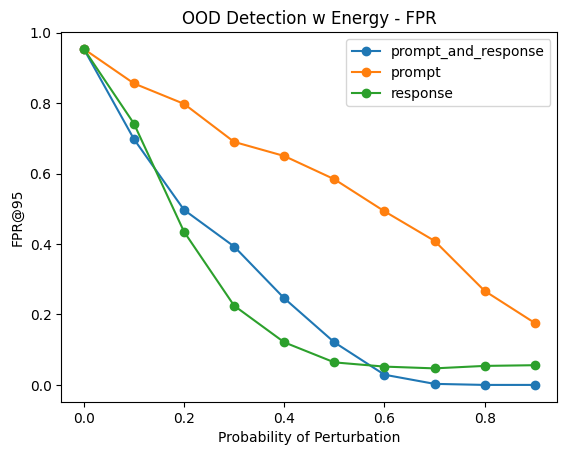

In [8]:
for inst in ['prompt_and_response', 'prompt', 'response']:
    fprs =  fpr_all[inst]
    plt.plot(list(fprs.keys()), list(fprs.values()), label=inst, marker='o')
plt.xlabel('Probability of Perturbation')
plt.ylabel('FPR@95')
plt.title('OOD Detection w Energy - FPR')
plt.legend()